# Getting started

This notebook shows how to get started with Quantus on tensorflow, using a very simple example.

In [ ]:
import numpy as np # noqa
import pandas as pd
import matplotlib.pyplot as plt # noqa
import tensorflow as tf # noqa
import tensorflow_datasets as tfds

import quantus

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [8]:
# Load datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
ds_train.element_spec

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
# Build a training pipeline
ds_train = ds_train.shuffle(128)
ds_train = ds_train.batch(128)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_train.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [10]:
# Build an evaluation pipeline
ds_test = ds_test.shuffle(128)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [11]:
x_batch, y_batch = ds_train.take(1).as_numpy_iterator().next()
x_batch.shape

2022-08-13 12:15:05.513140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-13 12:15:05.513164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

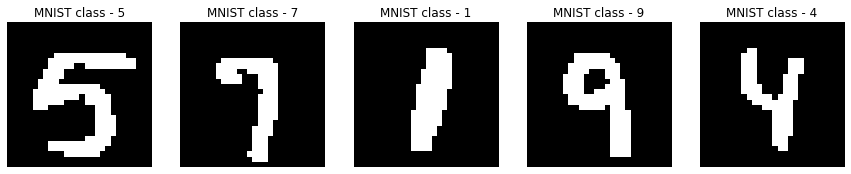

In [15]:
# Plot some inputs!
nr_images = 5

fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))

for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow((np.reshape(x, (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y}")
    axes[i].axis("off")

plt.show()

### 1.2 Train a model

In [14]:
model = quantus.cnn_2d_3channels_tf(28, 28, num_channels=1, num_classes=10)

model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
469/469 [==============================] - 33s 67ms/step - loss: 0.2584 - accuracy: 0.9223 - val_loss: 0.0779 - val_accuracy: 0.9743
Epoch 2/5
469/469 [==============================] - 28s 60ms/step - loss: 0.0647 - accuracy: 0.9804 - val_loss: 0.0657 - val_accuracy: 0.9777
Epoch 3/5
469/469 [==============================] - 32s 69ms/step - loss: 0.0453 - accuracy: 0.9859 - val_loss: 0.0490 - val_accuracy: 0.9844
Epoch 4/5
469/469 [==============================] - 40s 84ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0459 - val_accuracy: 0.9858
Epoch 5/5
469/469 [==============================] - 83s 177ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0444 - val_accuracy: 0.9867


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [16]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_intgrad = quantus.explain(model, x_batch, y_batch, **{'method': 'IntegratedGradients'})

Visualise attributions given model and pairs of input-output.

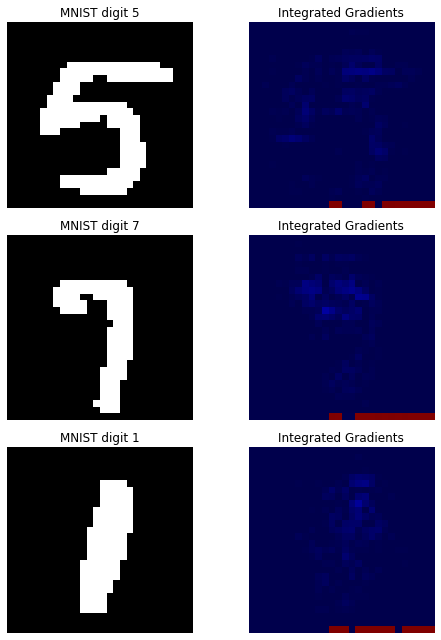

In [17]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [18]:
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "show_progressbar": True
}


metrics = {"max-Sensitivity": quantus.MaxSensitivity(**params_eval_maxs)}
xai_methods = {"IntegratedGradients": a_batch_intgrad}

results = quantus.evaluate(evaluation_metrics=metrics,
                           explanation_methods=xai_methods,
                           model=model,
                           x_batch=x_batch,
                           y_batch=y_batch,
                           agg_func=np.mean,
                           metrics = metrics,
                           xai_methods = xai_methods,
                           **{"explain_func": quantus.explain, "img_size": 28, "normalise": False, "abs": False})

df = pd.DataFrame(results)
df


argument 'img_size' is deprecated and will be removed in future versions.



,IntegratedGradients
max-Sensitivity,0.000069


In [19]:
# FIXME
# Calculate Selectivity (Ancona et al., 2019)
params_eval_slct = {
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "perturb_baseline": "uniform",
    "patch_size": 4,
    "nr_channels": 1,
    "show_progressbar": True
}

scores_intgrad_slct = quantus.Selectivity(**params_eval_slct)(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "img_size": 28, "normalise": True, "abs": True})


scores_intgrad_slct


argument 'img_size' is deprecated and will be removed in future versions.



AssertionError: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

## [Relative Stability](https://arxiv.org/pdf/2203.06877.pdf)

In [20]:
relative_stability_params = {
    'display_progressbar': True,
    'return_aggregate': True
}

ris = quantus.RelativeInputStability(**relative_stability_params)

ris_result = ris(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, method='IntegratedGradients')
ris_result

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/metrics/robustness_metrics/relative_stability.py:148: UserWarning: No "perturb_func" provided, using random noise as default
  warnings.warn(


DeviceArray(1339.4691, dtype=float32)

In [21]:
rrs = quantus.RelativeRepresentationStability(**relative_stability_params)

rrs_result = rrs(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, method='IntegratedGradients')
rrs_result

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/metrics/robustness_metrics/relative_stability.py:148: UserWarning: No "perturb_func" provided, using random noise as default
  warnings.warn(


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 1 and the array at index 1 has size 16

In [22]:
ros = quantus.RelativeOutputStability(**relative_stability_params)

ros_result = ros(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, method='IntegratedGradients')
ros_result

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/metrics/robustness_metrics/relative_stability.py:148: UserWarning: No "perturb_func" provided, using random noise as default
  warnings.warn(


DeviceArray(6.1716234e+09, dtype=float32)